In [24]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import math
from random import random
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from functools import reduce
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
import matplotlib.animation as ani
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error

In [2]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
plt.style.use('seaborn-dark-palette')
plt.rcParams["mathtext.fontset"] = "cm"

In [3]:
def hist_plot(index, data, title, x_lab, y_lab):

    rects = plt.bar(x = range(len(data)), height = data, width = 0.8, tick_label = index, color = 'lightskyblue')

    #plt.xticks([index + 0.2 for index in x], label_list)
    plt.ylabel(y_lab)
    plt.title(title)  

    for x,y in enumerate(data):
        plt.text(x, y, "%s"%round(y, 4), fontsize = 15, ha = 'center', va = 'bottom')
   
    plt.savefig('../figures/bird/%s.png'%title)
    plt.show()
    
def line_plot1(ts_1, ts_label_1, ts_2, ts_label_2, title):
    
    xs1 = list(range(0, len(ts_1)))
    xs2 = list(range(0, len(ts_2)))

    plt.rcParams['savefig.dpi'] = 300 
    plt.rcParams['figure.dpi'] = 300
    
    plt.plot(xs1, ts_1, c = 'forestgreen', label = ts_label_1, lw = 2)
    plt.plot(xs2, ts_2, c = 'red', label = ts_label_2, lw = 2)

    plt.title(title)
    plt.legend(loc = 'upper left')
    plt.savefig('../figures/bird/%s'%title)
    plt.show()
    
def line_plot2(ts_1, ts_label_1, ts_2, ts_label_2, ts_3, ts_label_3, title):
    assert len(ts_1) == len(ts_2)
    
    xs1 = list(range(0, len(ts_3)))
    xs2 = list(range(len(ts_3), len(ts_3) + len(ts_1)))
    
    plt.rcParams['savefig.dpi'] = 300 
    plt.rcParams['figure.dpi'] = 300
    
    plt.plot(xs2, ts_1, c = 'orangered', label = ts_label_1, lw = 1.5)
    plt.plot(xs2, ts_2, c = 'lightskyblue', label = ts_label_2, lw = 1.5)
    plt.plot(xs1, ts_3, c = 'forestgreen', label = ts_label_3, lw = 1.5)
    
    plt.title(title)
    plt.legend(loc='upper left')
    plt.savefig('../figures/bird/%s'%title)
    plt.show()

# Import data

In [4]:
weather = pd.read_csv('../dataset/radar/time_weather_filled.csv')
density = pd.read_csv('../dataset/radar/time_filled_ARIMA.csv')

# Correlation

In [5]:
density.corr()

KABR      KABX      KAKQ      KAMA      KAMX      KAPX      KARX  \
KABR  1.000000  0.013619 -0.039696  0.002457 -0.001952  0.048030  0.009275   
KABX  0.013619  1.000000 -0.026894  0.045215  0.188976 -0.014579 -0.025818   
KAKQ -0.039696 -0.026894  1.000000 -0.010393 -0.033955 -0.030053 -0.002805   
KAMA  0.002457  0.045215 -0.010393  1.000000  0.001671 -0.006015  0.002260   
KAMX -0.001952  0.188976 -0.033955  0.001671  1.000000 -0.015721 -0.008884   
...        ...       ...       ...       ...       ...       ...       ...   
KUEX  0.089589  0.007098 -0.022563  0.080607  0.016688 -0.043976  0.050892   
KVNX  0.026935  0.005293  0.010837  0.333256 -0.001433 -0.003729  0.049894   
KVTX  0.000409  0.013818 -0.013755  0.002709  0.018173  0.048122  0.031376   
KVWX -0.029134 -0.040356 -0.013732 -0.039598  0.001282  0.039792  0.047940   
KYUX -0.020418  0.043239  0.023517  0.051681  0.015372 -0.004572  0.180134   

          KATX      KBBX      KBGM  ...      KTLH      KTLX      KTWX  \
KABR -0.015727 -0.021133 -0.049889  ... -0.005561  0.029440  0.036691   
KABX  0.005859 -0.016117  0.005205  ... -0.007106  0.054758 -0.007491   
KAKQ  0.003671 -0.041202  0.027434  ...  0.064103 -0.043441  0.048972   
KAMA  0.065995  0.007319  0.013285  ... -0.027253  0.164807  0.108400   
KAMX  0.044363 -0.004510 -0.012283  ... -0.004823 -0.012440 -0.010470   
...        ...       ...       ...  ...       ...       ...       ...   
KUEX -0.042694 -0.015797 -0.050262  ... -0.040649  0.125606  0.176118   
KVNX  0.011146 -0.000785 -0.005681  ... -0.026648  0.200730  0.235607   
KVTX -0.004480  0.150508  0.002345  ... -0.019874  0.011646  0.014176   
KVWX  0.049247 -0.028631  0.039693  ... -0.039991 -0.028880 -0.033764   
KYUX  0.062020  0.023532  0.006774  ... -0.002424 -0.009215  0.029217   

          KTYX      KUDX      KUEX      KVNX      KVTX      KVWX      KYUX  
KABR -0.043462  0.049043  0.089589  0.026935  0.000409 -0.029134 -0.020418  
KABX  0.022276 -0.017818  0.007098  0.005293  0.013818 -0.040356  0.043239  
KAKQ  0.016737 -0.029824 -0.022563  0.010837 -0.013755 -0.013732  0.023517  
KAMA -0.007644  0.051638  0.080607  0.333256  0.002709 -0.039598  0.051681  
KAMX  0.016774 -0.010483  0.016688 -0.001433  0.018173  0.001282  0.015372  
...        ...       ...       ...       ...       ...       ...       ...  
KUEX -0.031479  0.211688  1.000000  0.145207  0.013265 -0.000630  0.018176  
KVNX -0.012128  0.064858  0.145207  1.000000  0.010256 -0.012421  0.014706  
KVTX  0.012240  0.018550  0.013265  0.010256  1.000000 -0.010394  0.102382  
KVWX  0.046774 -0.021408 -0.000630 -0.012421 -0.010394  1.000000  0.013068  
KYUX  0.040782  0.032973  0.018176  0.014706  0.102382  0.013068  1.000000  

[134 rows x 134 columns]

# Check if the data is stationary (Already done in the ARIMA)

In [6]:
def stationary(data):
    index = data.index
    columns = data.columns
    df_stats = pd.DataFrame(columns=['P-value'], index=columns)
    for col in columns:
        dftest = adfuller(data[col], autolag = 'AIC')
        df_stats.loc[col] = dftest[1]
    #df_stats1 = df_stats.transpose().values
    #df_stats1 = reduce(operator.add, df_stats1)
    #hist_plot(data = df_stats, index = df_stats.index, title = 'p-value of differentiation', x_lab = 'radar', y_lab = 'p-value')
    #fig = go.Figure(data = [go.Bar(x = df_stats.index, y = df_stats['P-value'], text = df_stats['P-value'], textposition = 'auto',)])
    #fig.show()
    return df_stats

In [7]:
stationary(density)

P-value
KABR     0.0
KABX     0.0
KAKQ     0.0
KAMA     0.0
KAMX     0.0
...      ...
KUEX     0.0
KVNX     0.0
KVTX     0.0
KVWX     0.0
KYUX     0.0

[134 rows x 1 columns]

# Random Forest Regression

In [14]:
def RFR(data, radar):
    lags = pd.DataFrame()
    for i in range(10,0,-1):
        lags['t-'+str(i)] = data.shift(i)
    lags['t'] = data.values
    lags = lags[13:]

    array = lags.values
    X = array[:,0:-1]
    y = array[:,-1]
    model = RandomForestRegressor(n_estimators = 500, random_state = 1)
    model.fit(X, y)


    feat_labels = lags.columns.drop('t')
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    for f in range(len(feat_labels)):
        print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))


    hist_plot(data = model.feature_importances_, index = lags.columns.drop('t'), title = 'importance of lags of %s'%radar, x_lab = 'lag variables', y_lab = 'feature importance')
    #names = lags.columns
    #fig = go.Figure(data = [go.Bar(x = lags.columns.drop('t'), y = model.feature_importances_, text = model.feature_importances_, textposition = 'auto',)])
    #fig.show()
    #print(model.feature_importances_)
    
    
    rfe = RFE(RandomForestRegressor(n_estimators = 500, random_state=1), 3)
    fit = rfe.fit(X, y)
    names = lags.columns.drop('t')
    columns_lags = []
    for i in range(len(fit.support_)):
        if fit.support_[i]:
            columns_lags.append(names[i])

    print("Columns with predictive power:", columns_lags)
    return columns_lags, lags

 1) t-10                           0.143852
 2) t-3                            0.140165
 3) t-5                            0.136094
 4) t-1                            0.126059
 5) t-9                            0.116378
 6) t-8                            0.104457
 7) t-2                            0.068282
 8) t-7                            0.067211
 9) t-6                            0.054835
10) t-4                            0.042666


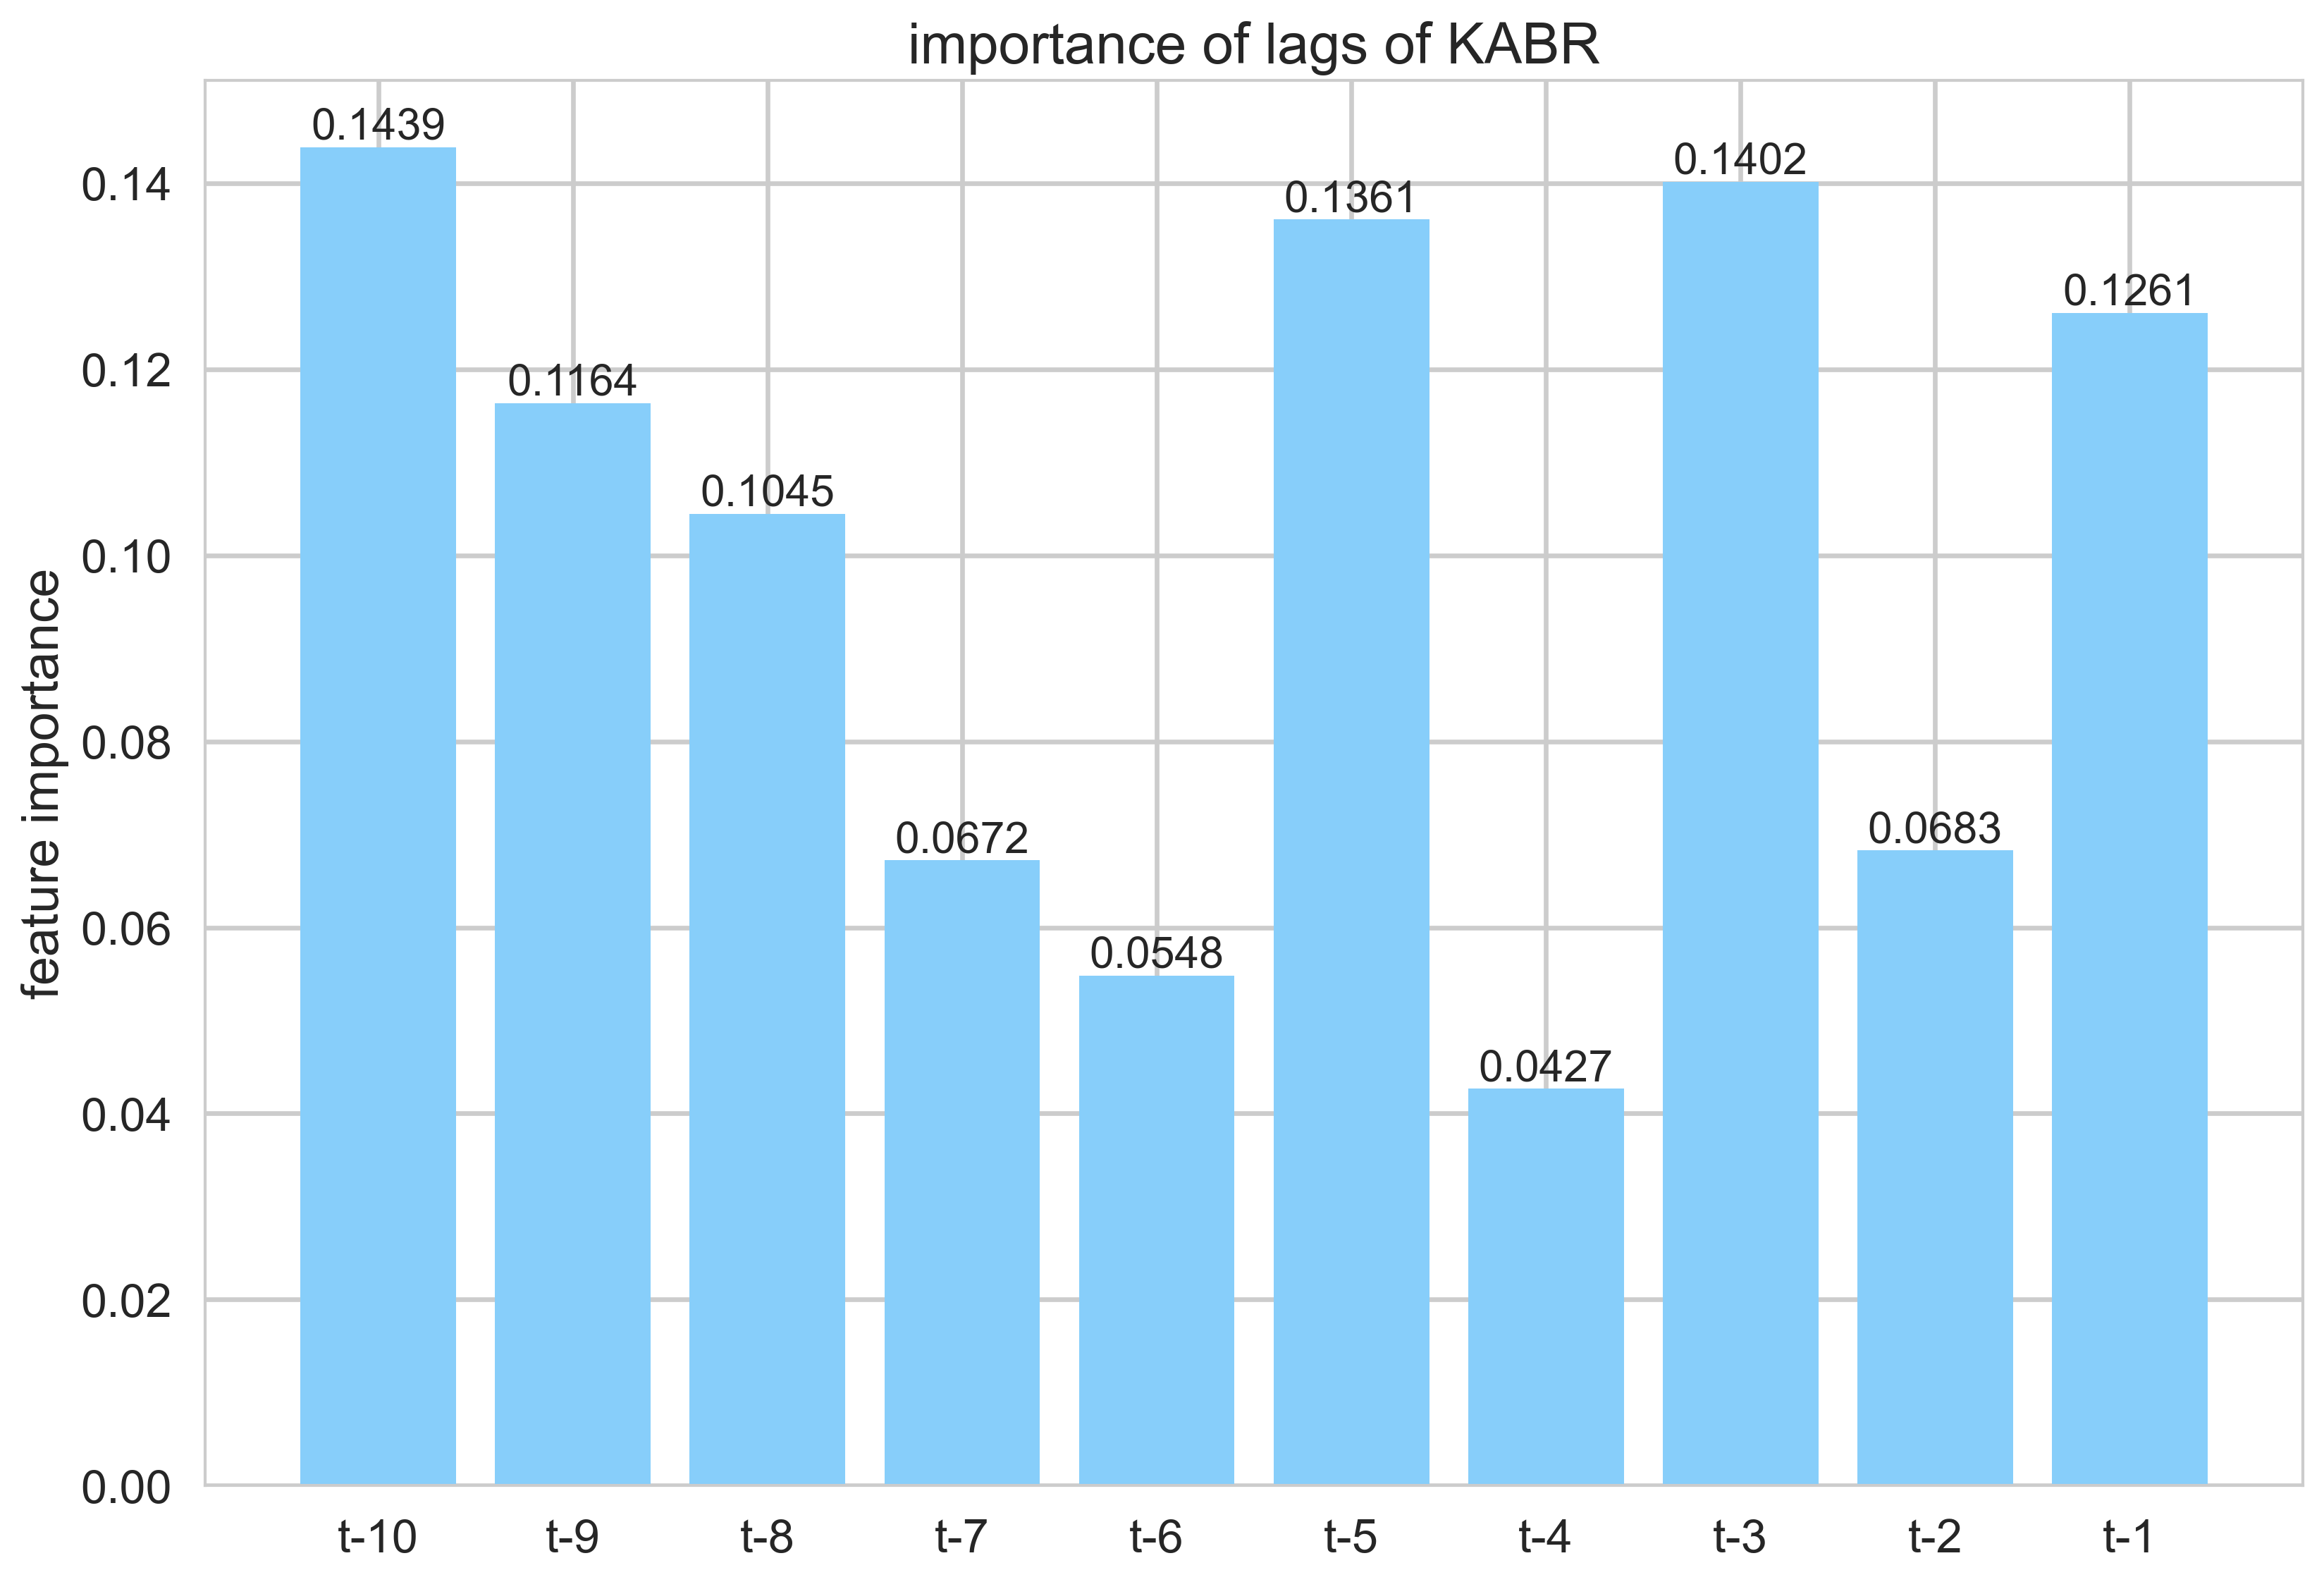

/Users/isabelle/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Columns with predictive power: ['t-10', 't-3', 't-1']


In [15]:
radar = 'KABR'
columns_lags, lags = RFR(density[radar], radar)

In [12]:
def Rolling_Mean(data, radar):
    columns = data.columns
    data_mean = pd.DataFrame(columns = columns)
    for col in columns:
        data_mean[col] = data[col].rolling(window = 80).mean()
    data_mean = data_mean.dropna()
    
    
    line_plot1(ts_1 = data[radar], ts_label_1 = radar, ts_2 = data_mean[radar], ts_label_2 = '%s - Rolling Mean'%radar, title = 'Rolling Mean')
    #fig = go.Figure()
    #fig.add_trace(go.Scatter(x = data.index, y = data[radar], mode = 'lines', name = radar))
    #fig.add_trace(go.Scatter(x = data.index, y = data_mean[radar], mode = 'lines', name = '%s - Rolling Mean'%radar))
    return data_mean

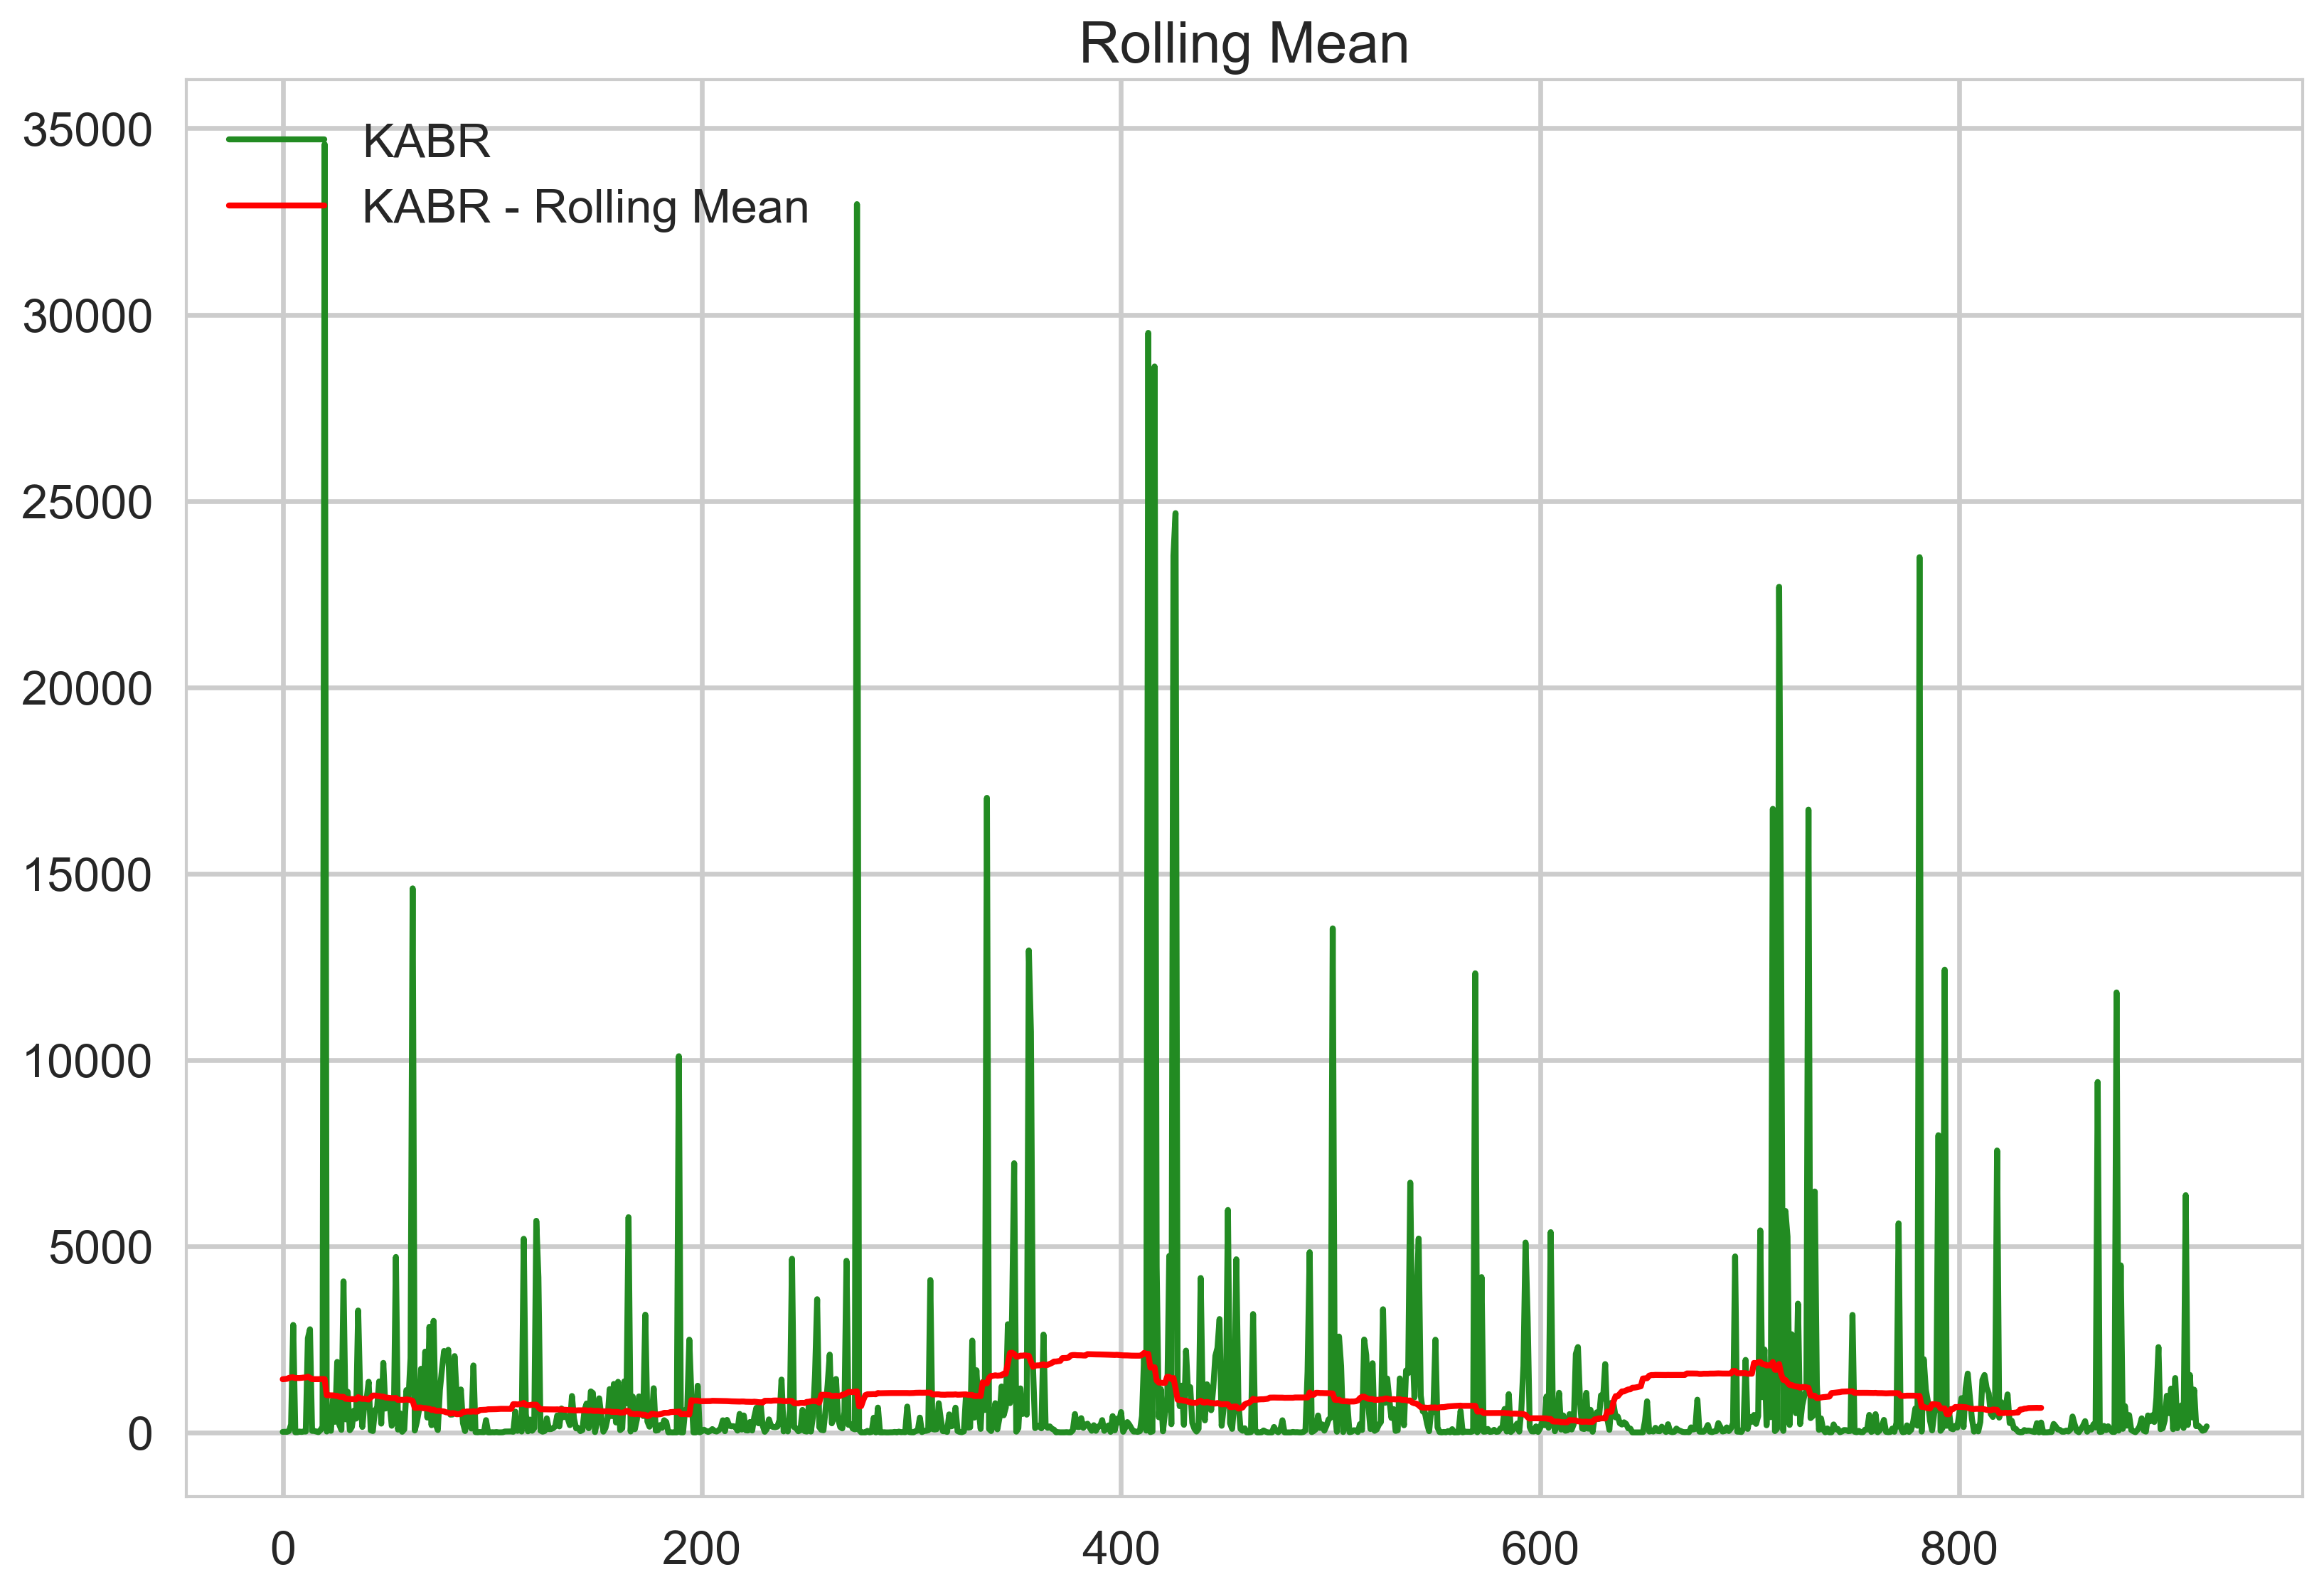

In [16]:
data_mean = Rolling_Mean(density, radar)

# Random Forest Model

In [22]:
def df_forecasting_single(data, radar, columns_lags, lags):
    df_forecasting = pd.DataFrame(data[radar])
    df_forecasting["%s_diff"%radar] = df_forecasting[radar].diff()
    for i in columns_lags:
        df_forecasting[i] = lags[i]#df_forecasting[radar].shift(i)
    df_forecasting = df_forecasting.dropna()
    df_forecasting["%s_rolling"%radar] = df_forecasting[radar].rolling(window = 80).mean()
    df_forecasting = df_forecasting.dropna()
    return df_forecasting
df_forecasting = df_forecasting_single(density, radar, columns_lags, lags)

In [37]:
def Random_Forest_Model(df_forecasting, coef):
    x = df_forecasting.iloc[:,1:]
    y = df_forecasting.iloc[:,0]
    x_train, x_valid = x[:int(coef * len(x))], x[int(coef * len(x)):]
    y_train, y_valid = y[:int(coef * len(y))], y[int(coef * len(y)):]
    mdl = rf = RandomForestRegressor(n_estimators = 500)
    mdl.fit(x_train, y_train)
    pred = mdl.predict(x_valid)
    mean_absolute_error(y_valid, pred)
    pred = pd.Series(pred, index = y_valid.index)
    
    
    line_plot1(ts_1 = y_valid.values, ts_label_1 = radar, ts_2 = pred.values, ts_label_2 = '%s - Forecasting'%radar, title = '%s forecasting (testing data)'%radar)
    #fig = go.Figure()
    #fig.add_trace(go.Scatter(x = y_valid.index, y = y_valid.values, mode = 'lines', name = radar))
    #fig.add_trace(go.Scatter(x = pred.index, y = pred.values, mode = 'lines', name = '%s - Forecasting'%radar))
    
    
    line_plot2(ts_1 = y_valid.values, ts_label_1 = '%s observed'%radar, ts_2 = pred.values, ts_label_2 = '%s - Forecasting (training + testing)'%radar, ts_3 = y_train.values, ts_label_3 = '%s training'%radar, title = '%s forecasting'%radar)
    #fig = go.Figure()
    #fig.add_trace(go.Scatter(x = y_train.index, y = y_train.values, mode = 'lines', name = '%s before'%radar))
    #fig.add_trace(go.Scatter(x = y_valid.index, y = y_valid.values, mode = 'lines', name = '%s observed'%radar))
    #fig.add_trace(go.Scatter(x = pred.index, y = pred.values, mode = 'lines', name = '%s - Forecasting'%radar))

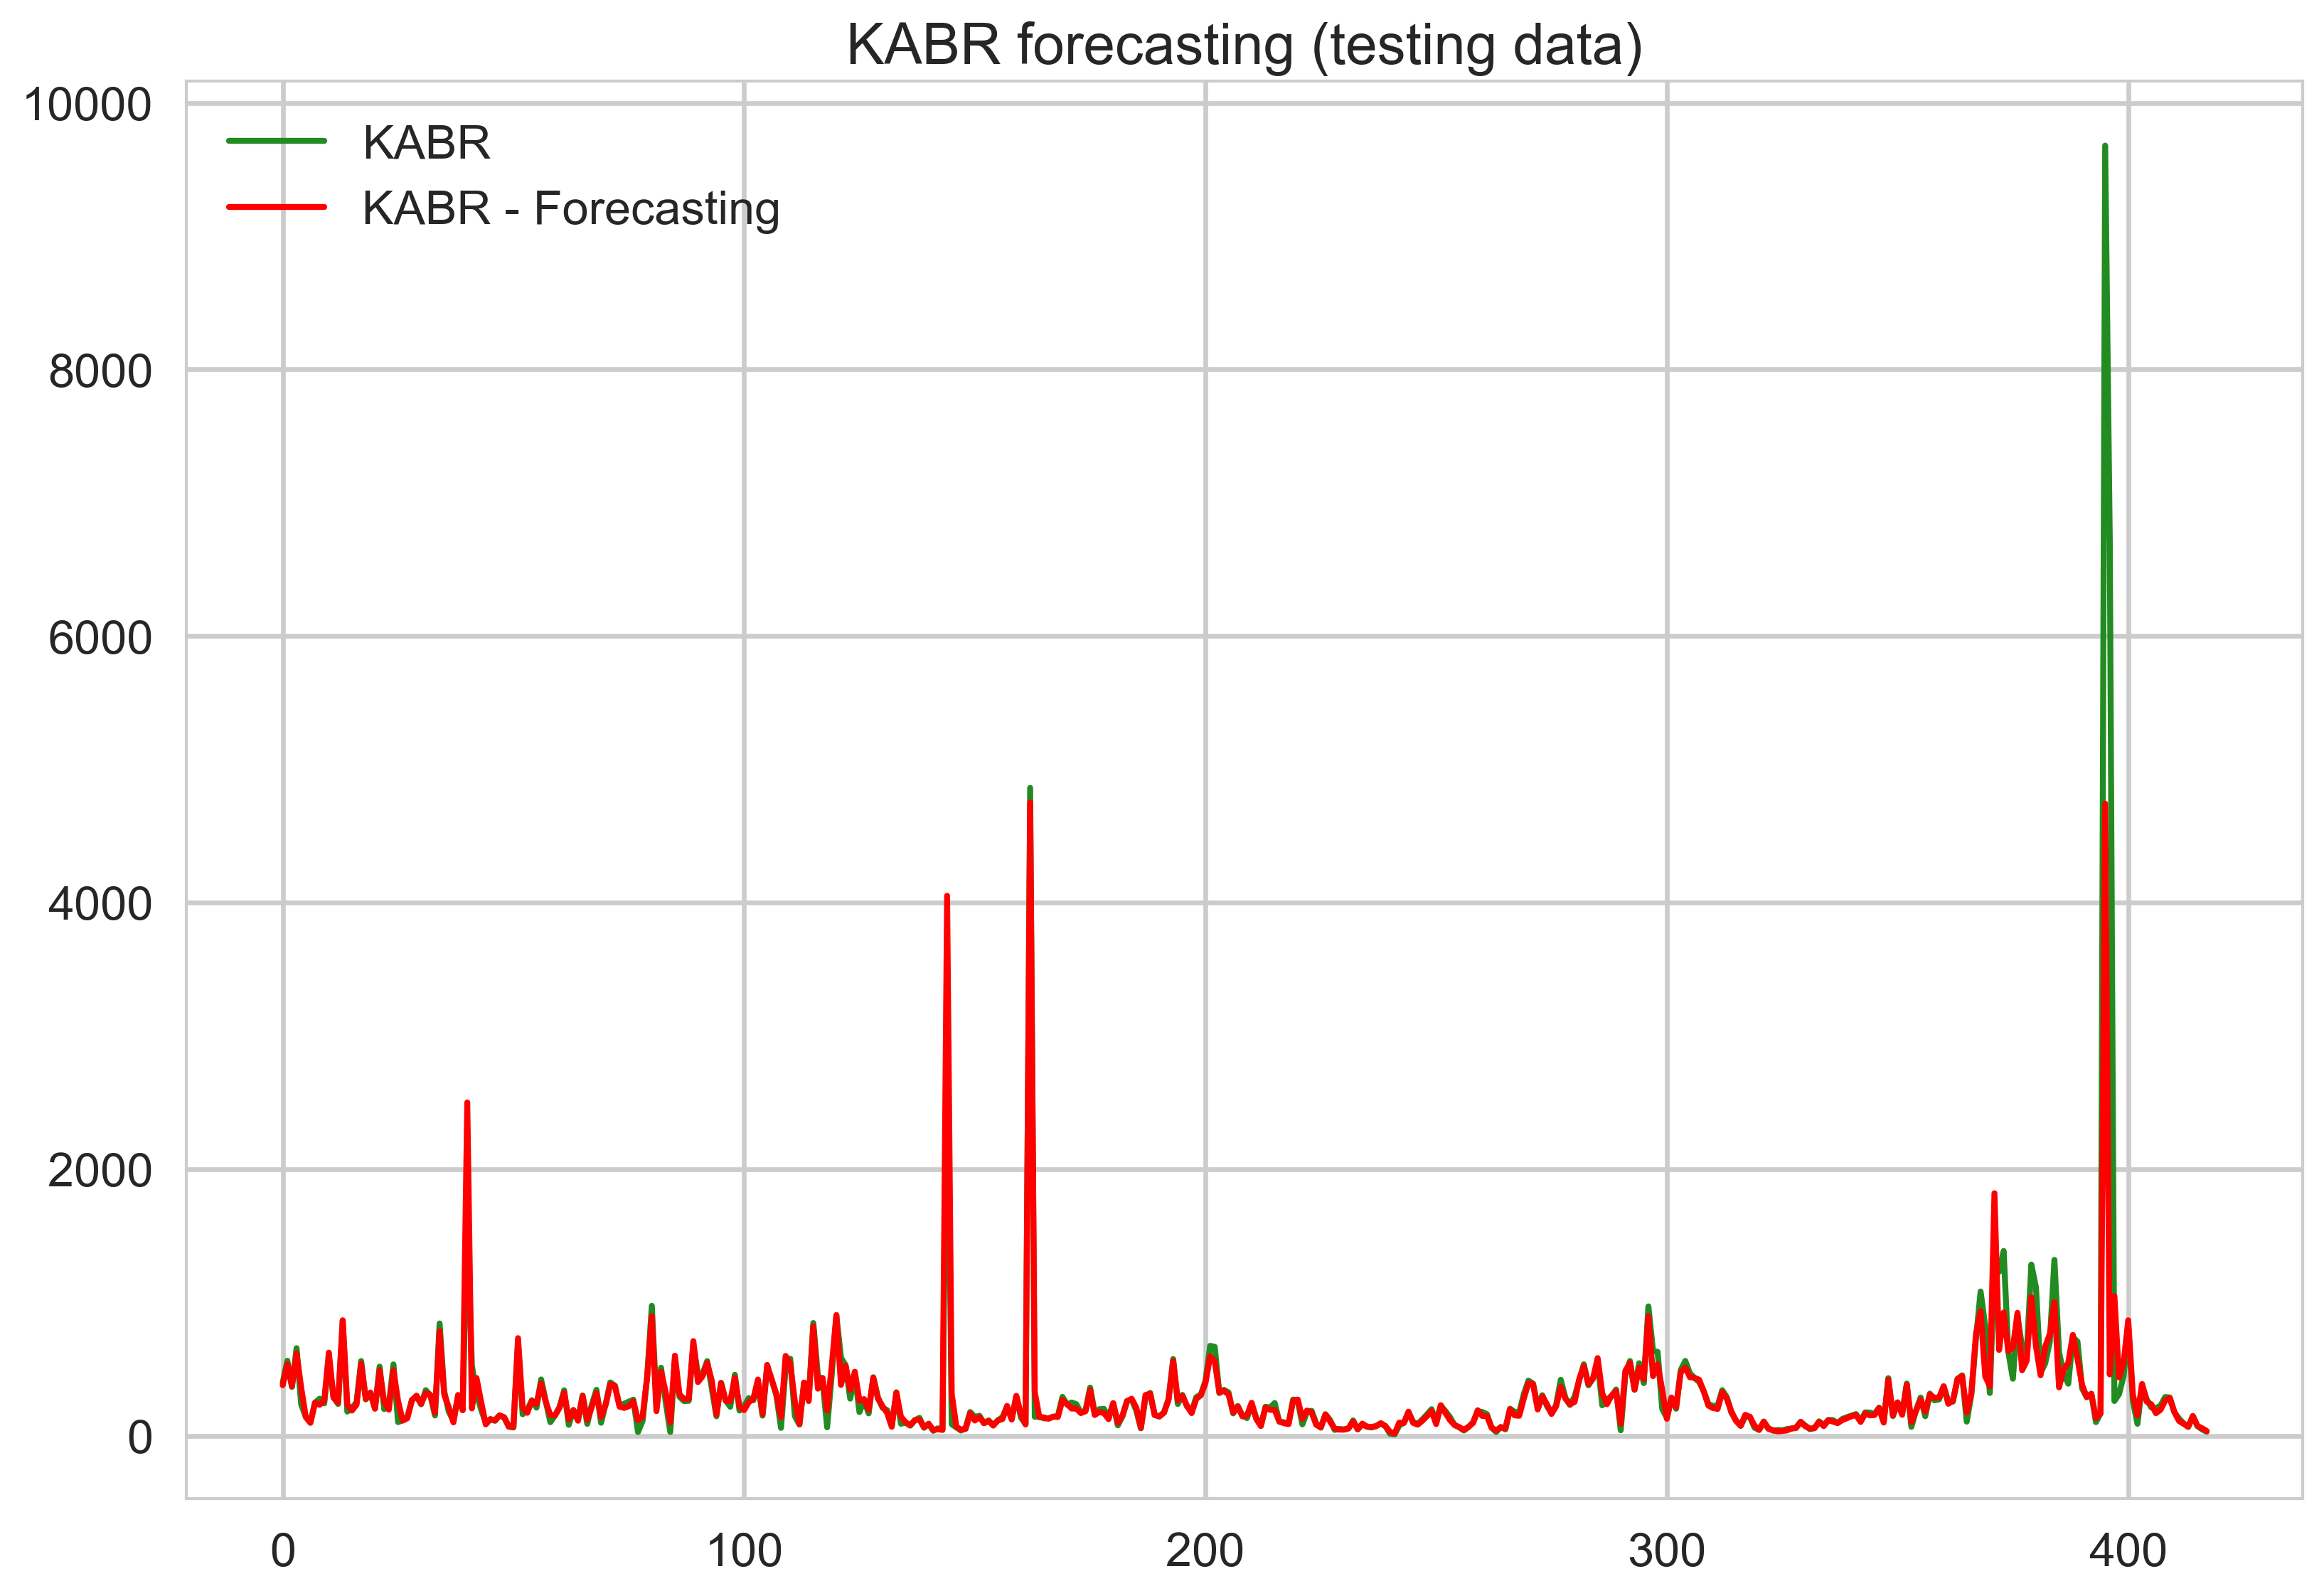

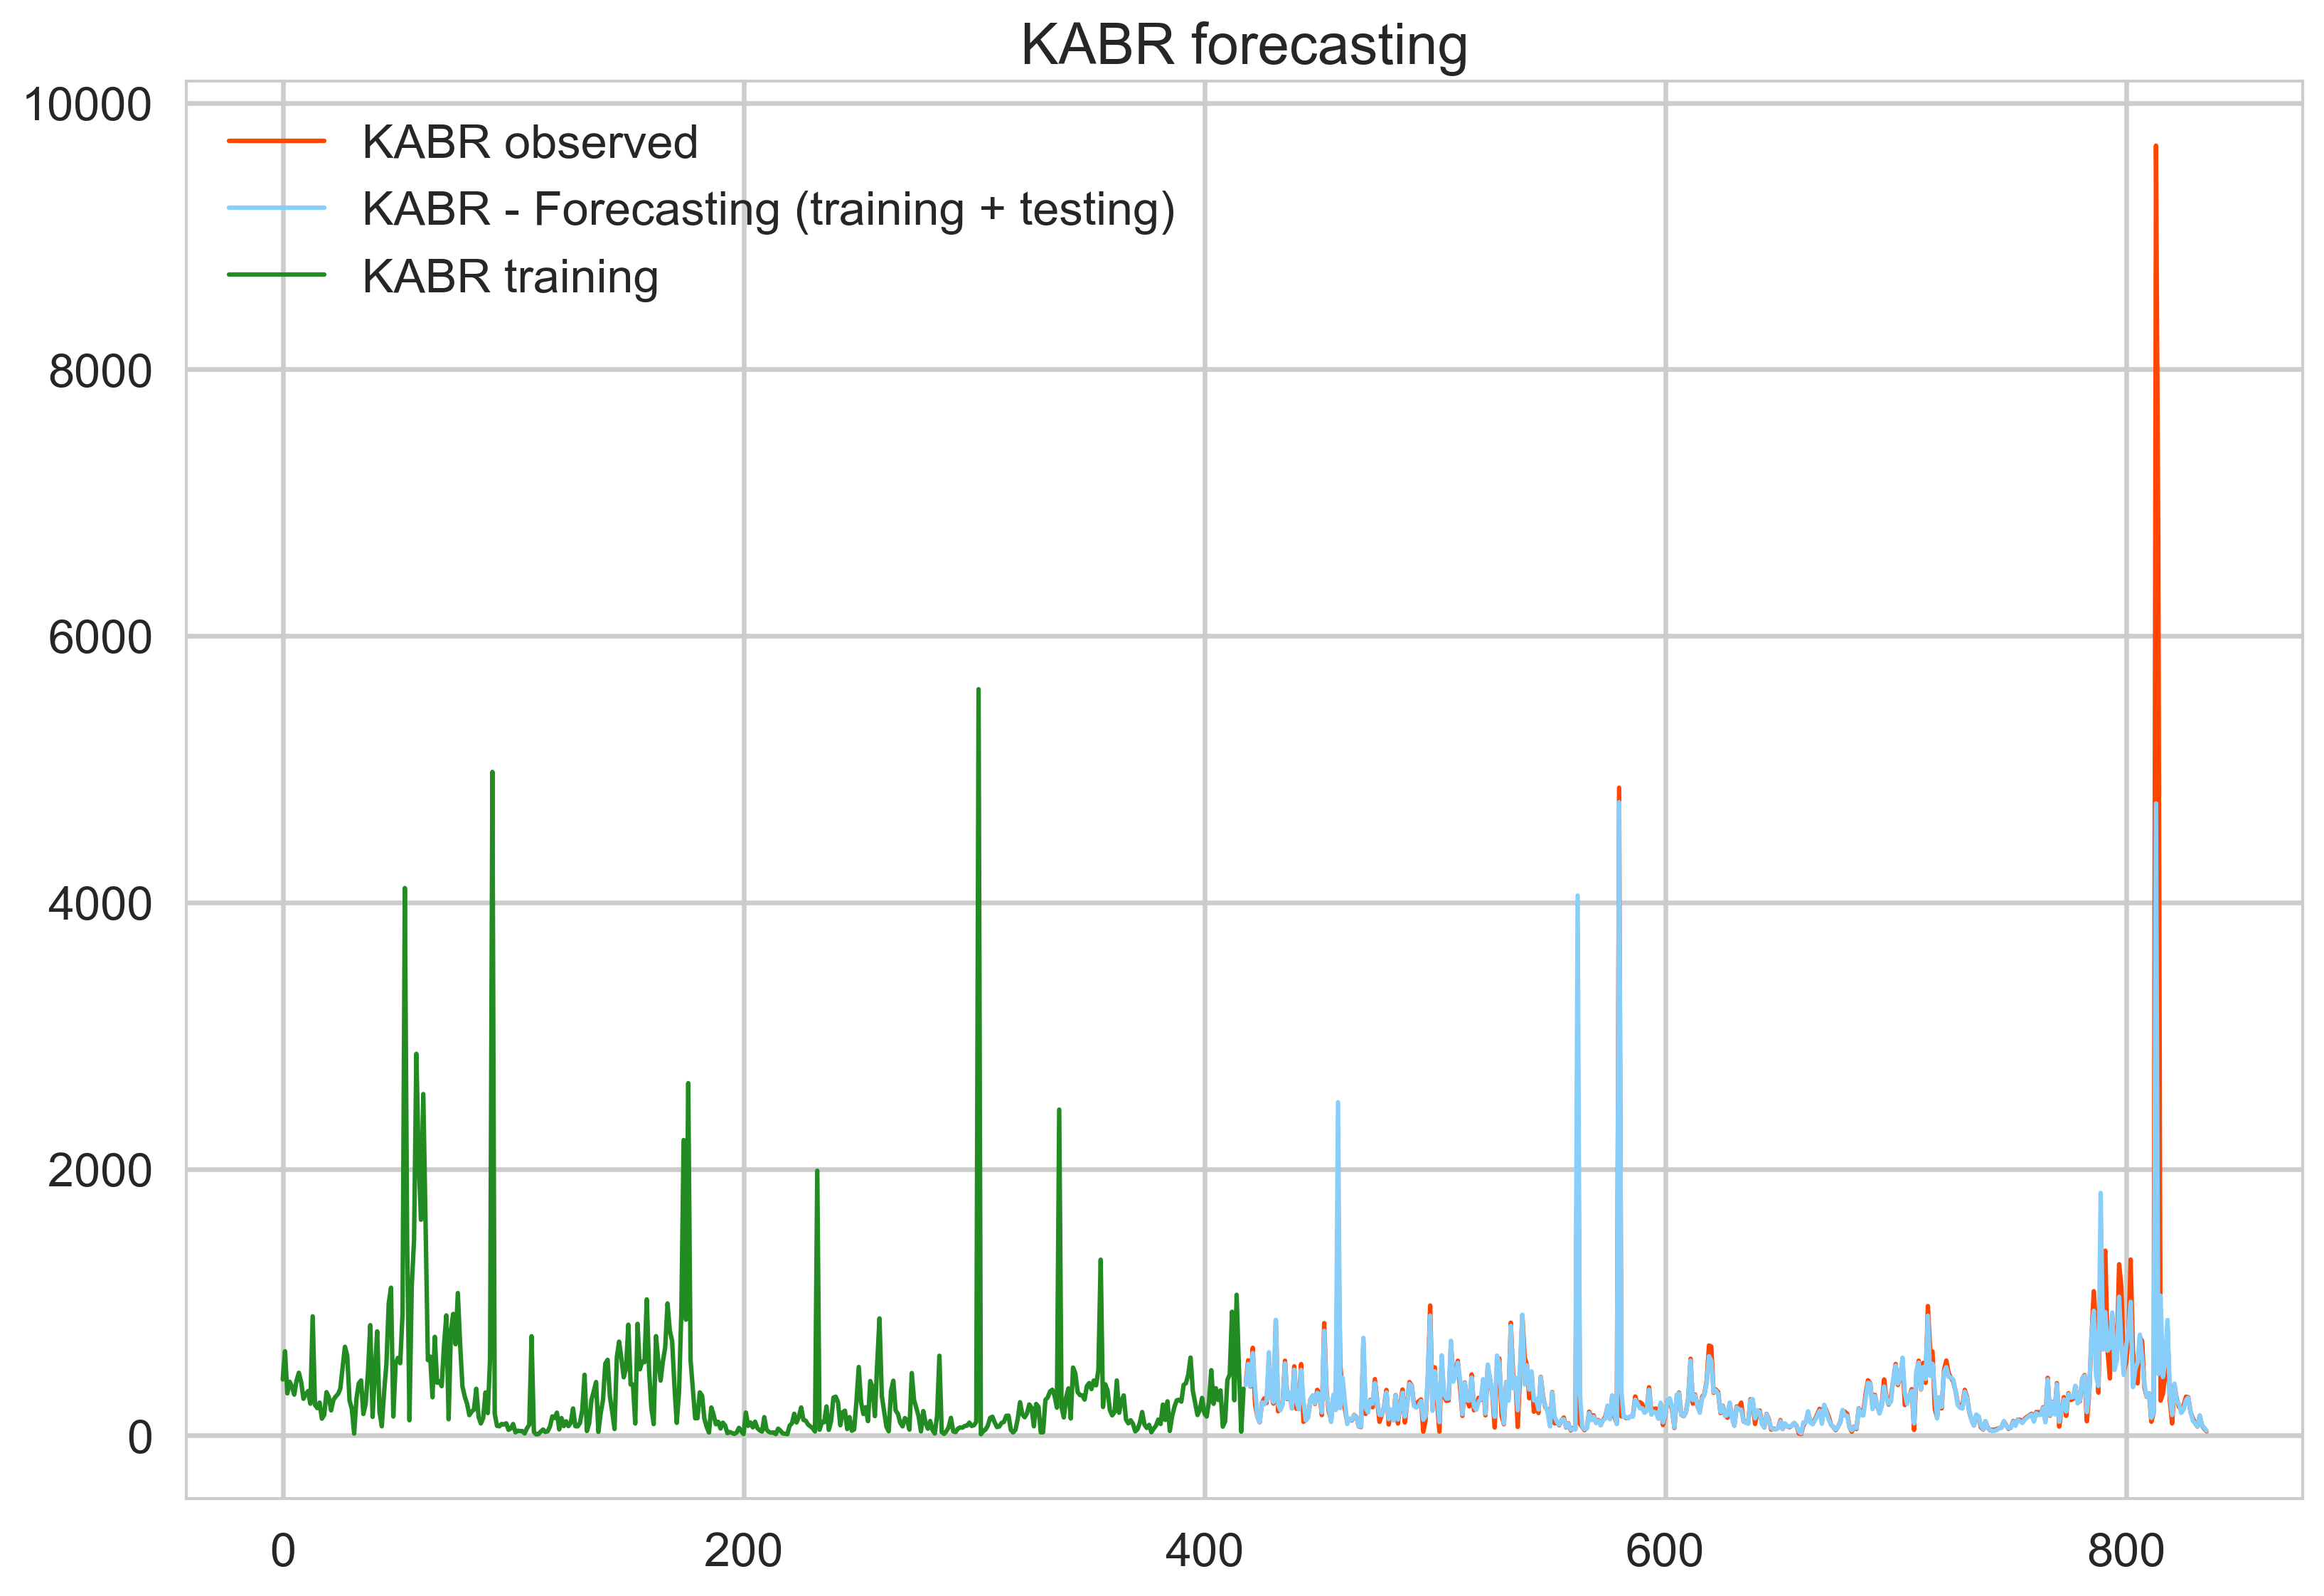

In [38]:
coef = 0.5
Random_Forest_Model(df_forecasting, coef)

In [34]:
data = density
coef = 0.5

In [35]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
score=[]
mse=[]
predict=pd.DataFrame()
for c in data.columns:
    #pre-processing data
    df_forecasting=pd.DataFrame(data[c])
    df_forecasting["var_diff"] = df_forecasting[c].diff()
    for i in range(4,0,-1):
        df_forecasting['t-'+str(i)] = df_forecasting[c].shift(i)
    df_forecasting=df_forecasting.dropna()
    df_forecasting["var_rolling"] = df_forecasting[c].rolling(window = 80).mean()
    df_forecasting= df_forecasting.dropna()
    #modeling 
    x=df_forecasting.iloc[:,1:]
    y=df_forecasting.iloc[:,0]
    x_train, x_valid = x[:int(coef * len(x))], x[int(coef * len(x)):]
    y_train, y_valid = y[:int(coef * len(y))], y[int(coef * len(y)):]
    mdl = RandomForestRegressor(n_estimators=100)
    mdl.fit(x_train, y_train)
    pred=mdl.predict(x_valid)
    predict[c+"_valid"]=y_valid.values
    predict[c+"_predict"]=pred
    m=mean_absolute_error(y_valid, pred)
    s=mdl.score(x_valid, y_valid)
    score.append([c, s])
    mse.append([c, m])
predict=predict.set_index(y_valid.index)
pred=pd.Series(pred, index=y_valid.index)
score=pd.DataFrame(score, columns=["Asset", "Score"])
score=score.set_index("Asset")

In [36]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Bar(
            x=score.index, y=score["Score"],
            text=score["Score"],
            textposition='auto',)])

fig.show()